# **`LightGBM`**

# Зачем [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/)?
- **`LightGBM`** похож на **`Catboost`** по интерфейсу
- Есть свои тонкости и костыли в настройке
- Разумеется, имеет свои преимущества в функционале
- На примере `LightGBM` погрузимся в настройку бустингов глубже
- Удивительно, но иногда конкретный бустинг оказывается сильнее остальных 
- Разберем выпендрежные штуки, важные тонкости оставим для практики

<div class="alert alert-info">

`LGBM (Light Gradient Boosted Machine)` - была описана Голинь К., и соавт. в статье 2017 года [«LightGBM: A Highly Efficient Gradient Boosting Decision Tree»](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree). 

Реализация вводит две ключевые идеи: `GOSS` и `EFB`.<br>
Фреймворк разрабатывается и поддерживается компанией Microsoft

С помощью `GOSS` (Градиентная односторонняя выборка) мы исключаем значительную часть экземпляров данных с небольшими градиентами и используем оставшиеся экземпляры для оценки прироста информации. Было доказано, что, поскольку экземпляры данных с большими градиентами играют более важную роль, `GOSS` может получить довольно точную оценку с гораздо меньшим размером данных. <br>
<br>

<div class="alert alert-info">
  

`EFB` или `Exclusive Feature Bundling` (объединение взаимоисключающих признаков) — это подход объединения разреженных (в основном нулевых) взаимоисключающих признаков, таких как категориальные переменные, закодированные onehot-кодированием. Это, по сути, тип автоматического подбора признаков. <br>
>… мы пакетируем взаимоисключающие признаки (то есть они редко принимают ненулевые значения одновременно), чтобы уменьшить количество признаков.
<br>

>Мы называем нашу новую реализацию `GBDT` с помощью `GOSS` и `EFB` - `LightGBM`. Наши эксперименты на нескольких общедоступных наборах данных показывают, что `LightGBM` ускоряет процесс обучения обычного `GBDT` более чем в 20 раз, достигая почти такой же точности.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
923,p-1607435n,Renault Sandero,standart,petrol,5.02,2011,615,2020,33.98,electro_bug,4.488966,2.244584e+07,0.00,183.226815,-5.417450,174,173
1280,v-2285960e,Kia Rio,economy,petrol,4.30,2015,81235,2015,41.18,engine_check,4.763161,1.570946e+07,0.19,157.000000,-30.270738,174,172
2307,k-7078453O,Renault Kaptur,standart,petrol,4.66,2013,47765,2022,27.37,engine_overheat,4.317184,8.714541e+06,0.10,194.000000,0.063272,174,171


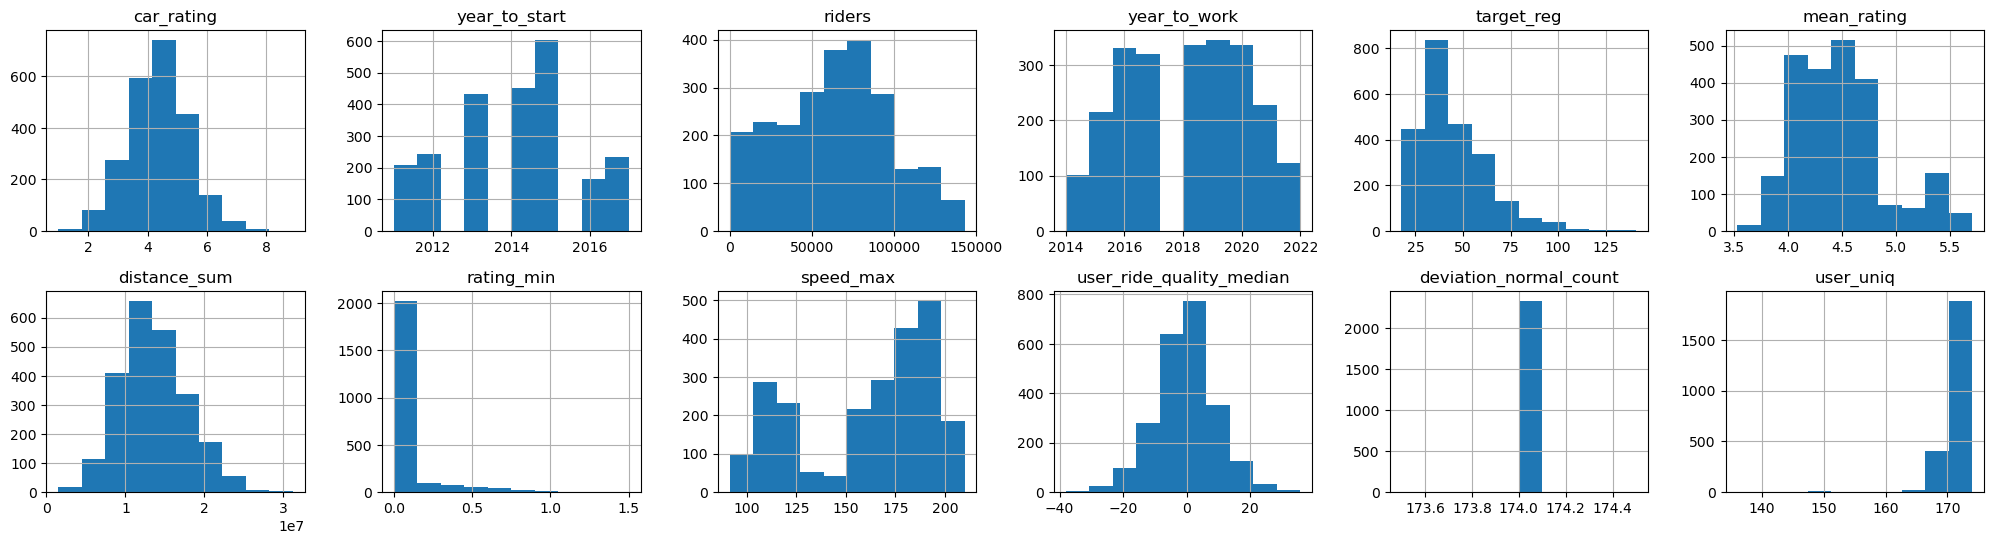

In [2]:
# Загружаем train-датасет который мы сохранили на шаге quickstart
df = pd.read_csv("quickstart_train.csv")
df.hist(figsize=(25, 6), layout=(-1, 6))
df.sample(3)

In [3]:
# Отбираем категориальные признаки
cat_cols = ["car_type", "fuel_type", "model"]
drop_cols = ["car_id", "target_reg", "target_class"]

X = df.drop(drop_cols, axis=1)
y = df["target_class"]

In [4]:
!pip install lightgbm -q

import lightgbm as lgb

## Оборачиваем данные в класс **`Dataset`**

<div class="alert alert-info">
    
* Как в библиотеке `CatBoost` есть класс `Pool` для создания датасетов, так и в `LightGBM` есть класс `Dataset` для той же цели. Как заявлено, является очень эффективным по потребляемой памяти, т.к. хранит не конкретные значения признаков, а только их дискретные бины.
* Число бинов, в свою очередь, можно отрегулировать при создании датасета, уменьшив параметры `max_bin` или `max_bin_by_feature`. 
* В документации заявлено, что можно подавать категориальные фичи без one-hot энкодинга. Фреймворк сам обработает, что выйдет быстрее до 8 раз.
* ⚠️ Однако, реализовано это специфическим образом: перед созанием класса `Dataset` категориальные фичи надо привести к целочисленному типу (`int`).
* ⚠️ Целевая переменная - (параметр `label`) также ограничен по возможным типам: `int`, `float` или `bool`

In [5]:
# переведем категориальные фичи в int с помощью  LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# таргет также придется перевести из строкового типа в целочисленный
le_tar = LabelEncoder()
y = le_tar.fit_transform(y)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

In [7]:
from lightgbm import Dataset

train_data = Dataset(
    X_train,
    y_train,
    categorical_feature=cat_cols,
    free_raw_data=False,
)

# Еще валидационный датасет для настройки ранней остановки
val_data = Dataset(
    X_test,
    y_test,
    categorical_feature=cat_cols,
    free_raw_data=False,
)

Ниже приведены другие важные параметры:

<div class="alert alert-info">

* `feature_name` — принимает список строк, определяющих имена столбцов.
* `reference` — (`Dataset` или `None` на выбор (`default=None`)) – Если это `Dataset` для валидации, то тренировочный `Dataset` должен быть указан как референсный.
* `group` – используется при решении задачи ранжирования (обучении Ранкера).
* `weight` – можно указать список весов для каждого экземпляра данных (неотрицательные числа) или установить позже, используя метод `set_weight()`.
* `params` – принимает словарь параметров, здесь, как раз, можно указать количество бинов (`max_bin` или `max_bin_by_feature`).
* `free_raw_data` (`bool`, optional (`default=True`)) – отвечает за освобождение памяти от сырых данных после создания датасета.

>Numpy/Array/Pandas object is memory expensive. If you are concerned about your memory consumption, you can save memory by:

>1. Set `free_raw_data=True` (default is True) when constructing the Dataset
>2. Explicitly set `raw_data=None` after the Dataset has been constructed
>3. Call `gc()`

# Два основных способа создания и обучения модели в **`LightGBM`**.


Хотя существуют и другие, и каждый имеет свои удобства, преимущества и недостатки. 

* 1. Метод `train()` класса `Booster` - наиболее простой и универсальный способ.
* 2. Класс `LGBMModel` с привычными методами `fit()`, `predict()`, который предоставляет подобный **scikit-learn API** для обучения и прогнозирования в `LightGBM`, а также позволяет использовать обученные модели в пайплайнах `sklearn` (например при стэккинге).

Рассмотрим каждый из способов на примере нашей задачи и познакомимся с основными параметрами.

In [8]:
from lightgbm import LGBMClassifier, train  # ,LGBMRegressor

### **Обучение модели методом `train()`**

<div class="alert alert-info">

Самый простой способ создать модель в `LightGBM` — использовать метод `train()`. <br>
Он принимает на вход словарь параметров и обучающий датасет.<br>
После обучения возвращается объект типа `Booster`, который является обученной моделью: её можно использовать для будущих предсказаний.

Ниже приведены некоторые из важных параметров метода `train()`.

* `params` — словарь, определяющий параметры модели. Нам просто нужно предоставить целевую функцию для начала работы в зависимости от типа задачи (классификация/регрессия). Позже мы ознакомимся с часто используемым списком параметров, которые можно передать в этот словарь.
*  `train_set` — принимает объект типа `Dataset`, который содержит информацию о признаках и целевых значениях.
* `num_boost_round` — указывает количество деревьев бустинга, которые будут использоваться в ансамбле (по умолчанию 100).
* `valid_sets` — принимает список `Dataset` объектов, которые являются выборками для валидации. Эти проверочные датасеты оцениваются после каждого цикла обучения.
* `valid_names` — принимает список строк той же длины, что и у `valid_sets`, определяющих имена для каждой проверочной выборки. Эти имена будут использоваться при выводе оценочных метрик для валидационных наборов данных, а также при их построении.
* `categorical_feature` — принимает список строк/целых чисел или строку `'auto'`. Если мы передадим список строк/целых чисел, тогда указанные столбцы из набора данных будут рассматриваться как категориальные.
* `verbose_eval` — принимает значения типа `bool` или `int`. Определяет с какой частотой выводить результаты расчета метрик на проверочных выборках.

In [9]:
params = {
    "objective": "multiclass",
    "num_class": 9,
    "verbosity": -1,
}

booster = train(
    params,
    train_set=train_data, # Принимает данные, как класс Dataset 
    valid_sets=(val_data),
    categorical_feature=cat_cols, 
    num_boost_round=10,
)

# В случае мультиклассификации метод predict() возвращает вероятности классов, поэтому используем np.argmax()
test_preds = np.argmax(booster.predict(X_test), axis=1)
print("\nTest Accuracy: %.2f" % accuracy_score(y_test, test_preds))


Test Accuracy: 0.78


Метод `predict()` также имеет ряд параметров и может возвращать `SHAP values`, `raw_score` и пр. <br>
Подробнее можно ознакомиться в [документации](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Booster.html#lightgbm.Booster.predict)

### **Обучение и создание моделей, используя обертку класса `Booster`**

<div class="alert alert-info">

Обертки для класса `Booster`, которые предоставляют подобный **scikit-learn API** для обучения и прогнозирования в `LightGBM`. Позволяют создать модель со списком параметров в качестве входных данных. Затем можно вызвать метод `fit()` для обучения, передав ему тренировочные данные и метод `predict()` для предсказания.<br>
Параметры, которые мы передали в виде словаря аргументу `params` метода `train()`, теперь можно напрямую передать конструктору класса-обертки для создания модели. <br>
Виды оберток класса `Booster`:
* `LGBMModel` — универсальная обертка, позволяет нам выполнять задачи как классификации, так и регрессии, указав цель (`objective`) задачи.<br> Например: `model = LGBMModel(objective="regression", n_estimators=10)` для задачи регрессии.
* `LGBMClassifier` — работает точно также, как LGBMModel, но только для задач классификации. Он также предоставляет метод `score()`, который оценивает точность переданных ему данных. Стоит обратить внимание, что `LGBMClassifier` предсказывает фактические метки классов для задач классификации с помощью метода `predict()`. Также предоставлен метод `pred_proba()`, если нам нужны вероятности целевых классов.
* `LGBMRegressor` — как следует из названия, он предназначен для задач регрессии.
* `LGBMRanker` — используется для задач ранжирования.

In [10]:
# Заметим, что метод fit() не принимает объект класса Dataset
# поэтому передадим номера категориальных столбцов в параметр cat_feature
clf = LGBMClassifier(
    objective="multiclass",
    n_estimators=10,
    num_class=9,
    seed=42,
    cat_feature=[0, 1, 2], # Нельзя передать список названий столбцов
)

clf.fit(
    X_train,
    y_train,
    eval_set=[
        (X_test, y_test),
    ],
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 13
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.167183
[LightGBM] [Info] Start training from score -2.244892
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.215039
[LightGBM] [Info] Start training from score -2.181301
[LightGBM] [Info] Start training from score -2.048362
[LightGBM] [Info] Start training from score -2.082120
[LightGBM] [Info] Start training from score -2.696877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier(cat_feature=[0, 1, 2], n_estimators=10, num_class=9,
               objective='multiclass', seed=42)

In [11]:
# В данном случае метод predict() возвращает сразу метку класса, поэтому np.argmax() не нужен
test_preds = clf.predict(X_test)
print("\nTest Accuracy: %.2f" % accuracy_score(y_test, test_preds))


Test Accuracy: 0.78


# Важные параметры **`LightGBM`**

<div class="alert alert-info">

Особенность `LightGBM` в том, что он поддерживает ряд алгоритмов бустинга, называемых типами бустинга. Тип бустинга указывается с помощью аргумента `boosting_type`.<br> Возможные значения:
* `gbdt` - градиеный бустинг над решающими деревьями (используется по умолчанию);
* `dart` - понятие отсева (`dropout`) вводится в `MART`, получаем `DART` 🎯 (как [`dropout`](https://ru.wikipedia.org/wiki/%D0%98%D1%81%D0%BA%D0%BB%D1%8E%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_(%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8)) слой в нейронках);
* `goss` - односторонняя выборка на основе градиента (`GOSS`).
* `rf` - `Random Forest`


<div class="alert alert-info">

`objective` — этот параметр позволяет нам определить целевую функцию, используемую для текущей задачи. Его значением по умолчанию является `regression`. На данный момент поддерживается 16 таких функций. Ниже приведен список часто используемых значений этого параметра.
    
`regression` (L2 loss), `regression_l1` (L1 loss), `tweedie`, `binary`, `multiclass`, `multiclassova`, `cross_entropy`, `lambdarank` <br>
    
[Другие доступные целевые функции](https://lightgbm.readthedocs.io/en/latest/Parameters.html#objective)

<div class="alert alert-info">

`metric` — данный параметр принимает метрики для расчета на оценочных наборах данных. Мы можем предоставить более одной метрики, и все они будут посчитаны на проверочных датасетах. Ниже приведен список наиболее часто используемых значений этого параметра.

`rmse`, `l2` , `l1` , `binary_logloss`, `multi_logloss`, `auc`, `cross_entropy` <br>
    
[Другие доступные метрики](https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric)

#  Еще параметры



<div class="alert alert-info">

**Базовые параметы**, но без `max_depth` 🦄
    
`num_iterations` — данный параметр является псевдонимом для `num_boost_round`, который позволяет нам указать число деревьев в ансамбле для создания модели. По умолчанию 100. <br>
`learning_rate` — этот параметр используется для определения скорости обучения. По умолчанию 0.1. <br>
`num_leaves` — данный параметр принимает целое число, определяющее максимальное количество листьев, разрешенное для каждого дерева. По умолчанию 31.<br>

<div class="alert alert-info">
    
**Регуляризация деревьев**    
    
* `max_depth` — этот параметр позволяет нам указать максимальную глубину, разрешенную для деревьев в ансамбле. По умолчанию -1, что позволяет деревьям расти, как можно глубже.
* `min_data_in_leaf` — данный параметр принимает целочисленное значение, определяющее минимальное количество точек данных (семплов), которые могут храниться в одном листе дерева. Этот параметр можно использовать для контроля переобучения. Значение по умолчанию 20.<br>
* `bagging_fraction` — этот параметр принимает значение с плавающей запятой от 0 до 1, которое позволяет указать, насколько большая часть данных будет случайно отбираться при обучении. Этот параметр может помочь предотвратить переобучение. По умолчанию 1.0.<br>
* `feature_fraction` — данный параметр принимает значение с плавающей запятой от 0 до 1, которое информирует алгоритм о выборе этой доли показателей из общего числа для обучения на каждой итерации. По умолчанию 1.0, поэтому используются все показатели.<br>
* `extra_trees` — этот параметр принимает логические значения, определяющие, следует ли использовать чрезвычайно рандомизированное дерево или нет.<br>

<div class="alert alert-info">
    
* `force_col_wise` — этот параметр принимает логическое значение, определяющее, следует ли принудительно строить гистограмму по столбцам при обучении. Если в данных слишком много столбцов, установка для этого параметра значения `True` повысит скорость процесса обучения за счет уменьшения использования памяти.<br>
* `force_row_wise` — этот параметр принимает логическое значение, определяющее, следует ли принудительно строить гистограмму по строкам при обучении. Если в данных слишком много строк, установка для этого параметра значения `True` повысит скорость процесса обучения за счет уменьшения использования памяти.<br>

<div class="alert alert-info">

* `early_stopping_round` — принимает целое число, указывающее, что мы должны остановить обучение, если оценочная метрика, рассчитанная на последнем проверочном датасете, не улучшается на протяжении определенного параметром числа итераций.
* `num_class` — если мы работаем с задачей мультиклассовой классификации, то этот параметр должен содержать количество классов.<br>
* `is_unbalance` — это логический параметр, который должен иметь значение `True`, если данные не сбалансированы. Его следует использовать с задачами бинарной и мультиклассовой классификации.<br>

Это далеко не полный список параметров, а наиболее важные. [Описание всех параметров](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

In [14]:
# посмотрим как меняется точность в зависимости от типа бустинга
boostings = ["gbdt", "dart", "goss"]

for name in boostings:
    clf = LGBMClassifier(
        objective="multiclass",
        n_estimators=10,
        learning_rate=0.1,
        num_class=9,
        reg_alpha=0.5,
        reg_lambda=0.3,
        seed=42,
        cat_feature=[0, 1, 2],
        boosting_type=name,
    )
    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        #verbose=False,
    )
    test_preds = clf.predict(X_test)
    print("{} accuracy: {:.2f}".format(name, accuracy_score(y_test, test_preds)))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 13
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.167183
[LightGBM] [Info] Start training from score -2.244892
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.215039
[LightGBM] [Info] Start training from score -2.181301
[LightGBM] [Info] Start training from score -2.048362
[LightGBM] [Info] Start training from score -2.082120
[LightGBM] [Info] Start training from score -2.696877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

# Тюнинг параметров.
    
**Чтобы повысить точность модели:** 📈🎯
* Использовать большой `max_bin` (замедляет обучение)
* Уменьшить `learning_rate`, увеличив число деревьев `num_iterations`
* Увеличить `num_leaves` (может привести к оверфиттингу)
* Попробовать `dart` 🦄 <br>

**Для борьбы с переобучением:** 🚀🚢
* Уменьшить `max_bin` и `num_leaves`
* Использовать `min_data_in_leaf` и `min_sum_hessian_in_leaf`
* Использовать [бэггинг](https://ru.wikipedia.org/wiki/%D0%91%D1%8D%D0%B3%D0%B3%D0%B8%D0%BD%D0%B3), указав `bagging_fraction` и `bagging_freq`
* Использовать сабсэмплинг признаков, установив `feature_fraction`
* Попробовать `lambda_l1`, `lambda_l2`, `min_gain_to_split` и `extra_trees` для регуляризации
* Установить `max_depth` для ограничения глубины дерева<br>

    

<div class="alert alert-info">
    
⚠️ Про `max_depth`: `LightGBM` строит асимметричное дерево, в отличие от других бустингов (разработчики указывают это как киллер-фичу), поэтому по умолчанию этот параметр выставлен в -1 (неограниченная глубина дерева). Но, чтобы не расти до бесконечности и не запомнить все данные, особенно на небольших датасетах, рекомендуется ограничивать глубину дерева другими параметрами: `num_leaves`, `min_data_in_leaf`, `min_sum_hessian_in_leaf`, `min_data_in_bin`, `min_gain_to_split`. А `max_depth` рекомендуется использовать либо на очень маленьких (для борьбы с оверфитом), либо на очень больших датасетах (чтобы уменьшить время обучения).

# <center> 📥📤 Сохранение и загрузка модели

<div class="alert alert-info">

Стоит обратить внимание на то, что для сохранения модели, обученной с использованием `LGBMModel`, `LGBMRegressor` и `LGBMClassifier`, нам сначала нужно получить их экземпляр `Booster` с помощью атрибута `booster_` модели, а затем сохранить его. `LGBMModel`, `LGBMRegressor` и `LGBMClassifier` не предоставляют функций сохранения и загрузки. Они доступны только с экземпляром `Booster`. <br>

**`LightGBM`** предоставляет нижеперечисленные методы для сохранения и загрузки моделей.
* `save_model()` — этот метод принимает имя файла, в котором сохраняется модель.
* `model_to_string()` — данный метод возвращает строковое представление модели, которое мы затем можем сохранить в текстовый файл.
* `lightgbm.Booster()` — этот конструктор позволяет нам создать экземпляр класса `Booster`. У него есть два важных параметра, которые могут помочь нам загрузить модель из файла или из строки.
    - `model_file` — этот параметр принимает имя файла, из которого загружается обученная модель.
    - `model_str` — данный параметр принимает строку, содержащую информацию об обученной модели. Нам нужно передать этому параметру строку, которая была сгенерирована с помощью `model_to_string()` после загрузки из файла.
<br>

Сохраним обученную выше модель на диск, а потом загрузим её обратно.

In [29]:
# получаем экземпляр класса Booster
booster = clf.booster_
booster.save_model("lgb.mod")

In [30]:
# Отметим, что после загрузки модель будет экземпляром класса Booster и соответственно метод predict() опять выдает вероятности
# Поэтому используем argmax()
loaded_booster = lgb.Booster(model_file="lgb.mod")
test_preds = np.argmax(loaded_booster.predict(X_test), axis=1)
print("Test Accuracy: %.2f" % accuracy_score(y_test, test_preds))

Test Accuracy: 0.78


# <center> Scheduler в **`LightGBM`**

<div class="alert alert-info">
    
🦄 В `LightGBM` реализован механизм, подобный шедулеру при обучении нейронных сетей, т.е. мы можем менять `learning_rate` в процессе обучения модели - иногда это бывает полезно, чтобы выжать из модели еще немного. Механизм реализован на базе `callback` функции `reset_parameter()` - данная функция обратного вызова позволяет нам сбрасывать `learning rate` после каждой итерации. Она принимает массив, размер которого совпадает с их количеством, или функцию, возвращающую новую скорость обучения для каждой итерации.<br>
В параметр `callbacks` методов `train()` и `fit()` можно подать список функций обратного вызова.<br>
Пример:
```python
booster = lgb.LGBMModel(objective=mean_sqaured_error, n_estimators=10,)
booster.fit(X_train, Y_train,
            eval_set=[(X_test, Y_test),], eval_metric="rmse",
            callbacks=[lgb.reset_parameter(learning_rate=np.linspace(0.1, 1, 10).tolist()),
                       lgb.early_stopping(stopping_rounds=5)])
```

# <center> Встроенная визуализация и **`feature importance`**

<div class="alert alert-info">
    
Экземпляр класса `Booster` имеет метод `feature_importance()`, который может возвращать нам важность признаков на основе значений выигрыша `booster.feature_importance(importance_type="gain")` и разделения `booster.feature_importance(importance_type="split")` деревьев.<br>

## Метод `plot_importance()`

<div class="alert alert-info">

Встроенный метод `plot_importance()` принимает экземпляр класса `Booster` и с его помощью отображает важность признаков. У данного метода есть параметр `importance_type`. Если он установлен в значение `split`, то график будет отображать количество раз, которое каждый показатель использовался для разбиения. Если установлено значение `gain`, то будет показан выигрыш от соответствующих разделений. Значение параметра `importance_type` по умолчанию `split`.<br>
Параметр `max_num_features` принимает целое число, определяющее, сколько признаков включить в график.

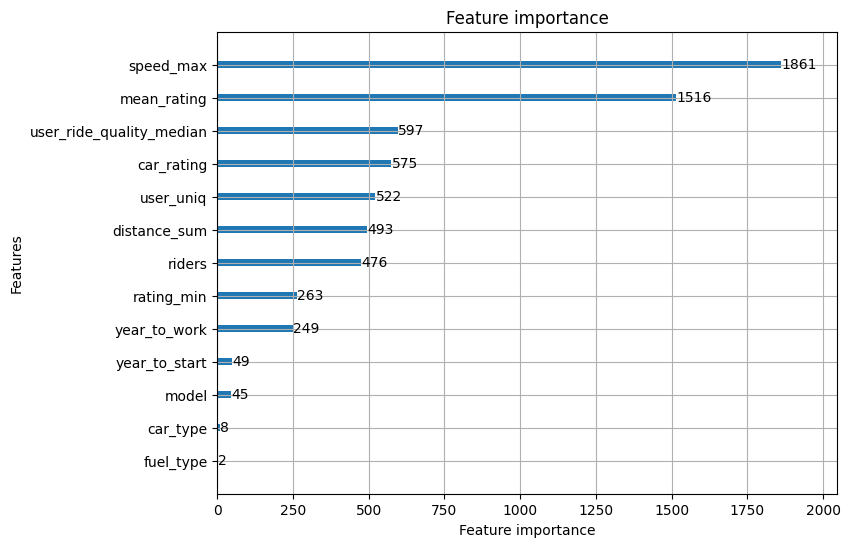

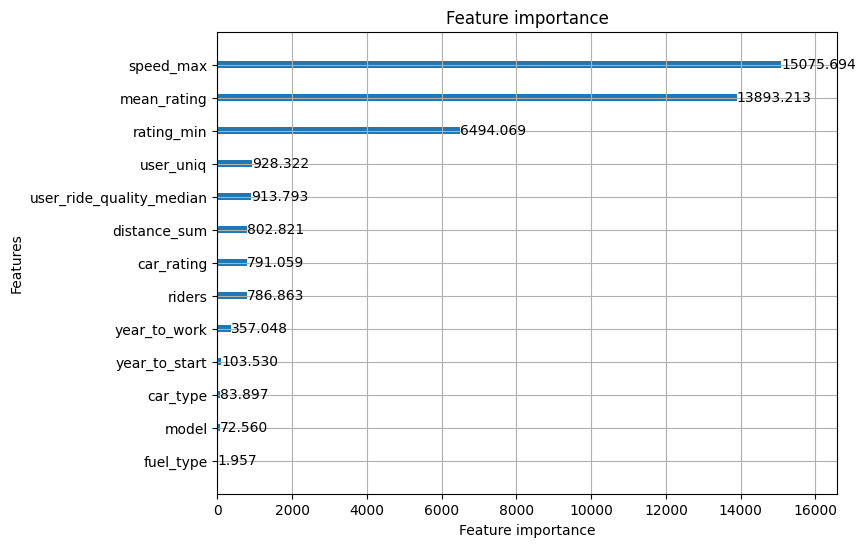

In [31]:
# Посмотрим на разные виды импортансов
lgb.plot_importance(booster, figsize=(8, 6), importance_type="split")
lgb.plot_importance(booster, figsize=(8, 6), importance_type="gain");

## Метод `plot_split_value_histogram()`
Этот метод принимает на вход экземпляр класса `Booster` и имя/индекс признака. Затем он строит гистограмму значений разделения (split value) для выбранного признака.

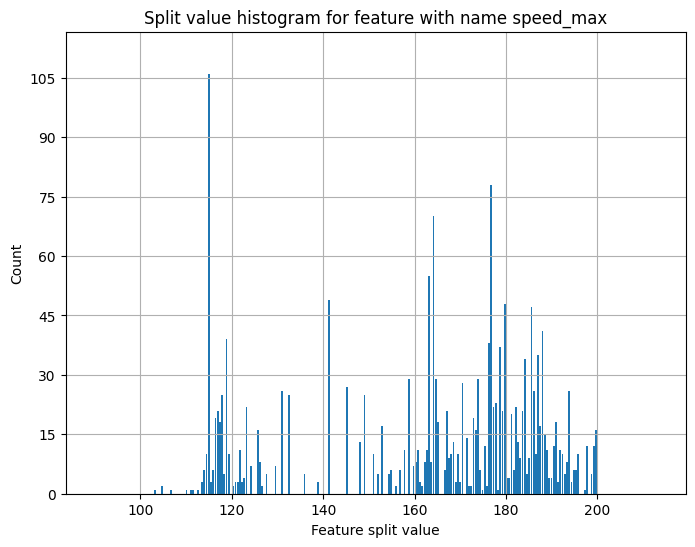

In [32]:
lgb.plot_split_value_histogram(booster, feature="speed_max", figsize=(8, 6));

# <center> Кастомные  **`loss`** & **`eval`** функции
    
<div class="alert alert-info">
    
🦄 В некоторых соревнованиях организаторы считают скор для построения лидерборда на какой-нибудь необычной функции оценки (`eval metric`), которая хорошо работает на конкретной задаче, но более нигде не встречается. Чаще всего, даже предоставляют формулу для расчета, в таком случае может быть полезно написать собственные кастомные функции для обучения бустинга.
`LightGBM` позволяет нам определять наши собственные функцию потерь и функцию оценки, если мы не хотим использовать метрики, предоставленные фреймворком.
Чаще всего используются 2 способа реализации кастомных функций:
* 1. Наиболее простой: импортировать готовую функцию из другого фреймворка (например из `sklearn`) и допилить до нужного формата (см. пример)
* 2. Написать собственную функцию с нуля.
    

### Функция потерь (`objective`)
Нужно создать функцию, которая принимает список прогнозируемых и фактических меток в качестве входных данных и возвращает первую и вторую производные функции потерь, вычисленные с использованием предсказанных и фактических значений. Далее мы можем при инициализации модели передать параметру `objective`  определенную нами функцию оценки/потерь. В случае использования метода `train()`, мы должны предоставить ее через параметр `fobj`.

### Функция оценки (`feval`)
Создаем функцию, которая принимает на вход список предсказаний и фактических целевых значений. Она должна возвращать строку, определяющую название метрики, результат ее расчета и логическое значение, выражающее, стоит ли стремиться к максимизации данной метрики или к ее минимизации. В случае, когда чем выше значение метрики, тем лучше, должно быть возвращено `True`, иначе — `False`. Нужно указать ссылку на эту функцию в параметре `feval`, если мы используем метод `train()` для обучения нашей модели. При передаче в `fit()` нам нужно присвоить данную ссылку параметру `eval_metric`.

In [33]:
# Рассмотрим в качестве примера реализацию кастомной метрики оценки
from sklearn.metrics import precision_score


def precision_score_(preds: np.ndarray, data, threshold: float = 0.5, num_classes: int = 9):
    """Calculate recall_score"""
    
    label = data.get_label()
    preds = preds.reshape(num_classes, -1).T
    pred_label = np.argmax(preds, axis=1)
    rs = precision_score(pred_label, label, average="macro", zero_division=0)
    
    return "precision_score_best", rs, True  # eval_name, eval_result, is_higher_better

In [34]:
booster = lgb.train(
    params,
    train_set=train_data,
    valid_sets=(val_data,),
    num_boost_round=10,
    feval=[precision_score_],
)

/home/jovyan/.local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[1]	valid_0's multi_logloss: 1.68905	valid_0's precision_score_best: 0.762309
[2]	valid_0's multi_logloss: 1.43158	valid_0's precision_score_best: 0.776515
[3]	valid_0's multi_logloss: 1.24981	valid_0's precision_score_best: 0.779801
[4]	valid_0's multi_logloss: 1.12568	valid_0's precision_score_best: 0.777885
[5]	valid_0's multi_logloss: 1.02312	valid_0's precision_score_best: 0.79044
[6]	valid_0's multi_logloss: 0.940656	valid_0's precision_score_best: 0.784693
[7]	valid_0's multi_logloss: 0.87623	valid_0's precision_score_best: 0.783361
[8]	valid_0's multi_logloss: 0.822769	valid_0's precision_score_best: 0.782962
[9]	valid_0's multi_logloss: 0.779806	valid_0's precision_score_best: 0.78514
[10]	valid_0's multi_logloss: 0.740605	valid_0's precision_score_best: 0.785187
